## 1.Importing Libraries

In [84]:
import sys
import os

import gc
import warnings

from subprocess import check_output

from datetime import datetime
from glob import glob
from tqdm import tqdm

import numpy as np
from numpy.linalg import svd
import scipy.stats as stats
from scipy.sparse.linalg import svds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as se

from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model


from surprise import Dataset, NormalPredictor, Reader, SVD

import multiprocess
from functools import partial




from ipynb.fs.full.metrics import (
    hit_rate_at_k_score,
    mean_average_precision_at_k_score,
    ndcg_score_at_k,
)

In [85]:
# se.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
# Set pandas view options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 30)
warnings.filterwarnings("ignore")
#%matplotlib inline

In [86]:
# The goal of a competition is to predict which previously purchased products will be in a user’s next order.

# 2.Loading Data

In [87]:
processed_data_path = "/Users/Artem_Boltaev/Documents/EPAM Projects/6. RecSys_course/source_code/recsys_course_epam/data/processed/instacart-market-basket-analysis-processed"
print(check_output(["ls", processed_data_path]).decode("utf8"))

df_test.csv
df_test_mod.csv
df_train.csv
df_train_mod.csv



In [88]:
df_train = pd.read_csv(processed_data_path + "/df_train.csv")
df_test = pd.read_csv(processed_data_path + "/df_test.csv")

df_train_mod = pd.read_csv(processed_data_path + "/df_train_mod.csv")
df_test_mod = pd.read_csv(processed_data_path + "/df_test_mod.csv")

In [89]:
items_pred = np.array(df_train_mod['product_id'].unique())
items_pred

array([33120, 28985,  9327, ..., 33097, 38977, 23624])

# 3.Data Preprocessing

In [6]:
df = pd.concat([df_train, df_test], axis=0)
df.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


# 4.Model Building

In [7]:
# A bunch of functions to help us with the model

# normalizing scores to 1
def normalization_ndcg(y_true, y_pred):

    y_true_norm = []
    y_pred_norm = []

    for i in range(len(y_true)):
        y_true_norm.append([x / x for x in y_true[i]])




    for i in range(len(y_pred)):
        y_pred_norm_row = []
        for el in y_pred[i]:
            if el in y_true[i]:
                score = 1
            else:
                score = 0
            y_pred_norm_row.append(score)

        y_pred_norm.append(y_pred_norm_row)

    y_pred_norm = np.array(y_pred_norm)
    y_true_norm = np.array(y_true_norm)

    y_true_norm = y_true_norm.astype(int)
    y_pred_norm = y_pred_norm.astype(int)

    return y_true_norm, y_pred_norm

def get_scores(y_true, y_pred, k):
    y_true = y_true["y_true"].apply(pd.Series).to_numpy()
    y_pred = y_pred["y_pred"].apply(pd.Series).to_numpy()

    hit_rate_at_k = hit_rate_at_k_score(y_true, y_pred, k)
    mean_average_precision_at_k = mean_average_precision_at_k_score(y_true, y_pred, k)

    # normalizing scores to 1
    y_true_norm, y_pred_norm = normalization_ndcg(y_true, y_pred)
    ndcg_at_k = ndcg_score_at_k(y_true_norm, y_pred_norm, k, gains="linear")

    print(
        "hit_rate_at_k",
        hit_rate_at_k,
        "\n" "mean_average_precision_at_k",
        mean_average_precision_at_k,
        "\n" "ndcg_at_k",
        ndcg_at_k,
    )


In [9]:
y_true = (
    df_test.groupby("user_id")["product_id"]
    .agg(lambda x: list(x))
    .reset_index(name="y_true")
).iloc[:n_users_for_rec]
y_true

,user_id,y_true
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."
...,...,...
995,1557,"[23288, 46521, 37710, 21195, 17168, 5258]"
996,1559,"[34610, 21477, 9106, 7695, 42052, 24993, 1999,..."
997,1562,"[38739, 37931, 41149, 26769, 42342, 2380, 1541..."
998,1565,"[35629, 21927, 18908]"


In [46]:
n_users_for_rec = 1000
#n_users_for_rec = df_test['user_id'].unique()
n_rec = 5

n_users_train = df_train_mod['user_id'].max()
n_products_train = df_train_mod['product_id'].max()

test_user_id_list = y_true['user_id'].unique()
train_product_id_list = df_train_mod['product_id'].unique()

## 4.1 Most popular recommender

In [ ]:
# most popular products
cnt_product = df_train["product_id"].value_counts().reset_index().head(20)
cnt_product.columns = ["product_id", "frequency_count"]
cnt_product.sort_values('frequency_count', ascending=False, inplace=True)
cnt_product

In [ ]:
y_pred_most_popular = y_true["user_id"]
y_pred_most_popular = pd.DataFrame(y_pred_most_popular)
y_pred_most_popular["y_pred"] = 24852
y_pred_most_popular

### 4.1.1 Evaluation

In [ ]:
get_scores(y_true, y_pred_most_popular, k=3)

## 4.2 SVD
#performs inference for users batches to overcome memory issue

In [ ]:
# A bunch of functions to help us with the model

def cosine_similarity(a, b):
    '''
    This function will calculate the cosine similarity between two vectors
    '''
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def get_similarities(mat, id_):
    '''
    This function will use the cosine similarity function to generate a similarity 
    dictionary assocaited to an id the user passes in. The similarity dictionary will
    have the ids as the keys and the similarity in comparison to the user input id as
    the values.
    
    params:
        mat (List -> List) : A 2-D array assocaited to either the user / item matrix
                             after SVD
        id_ (Integer) : The id of the user / item you want to find similarities for.
                        The id must be in the range of the input matrix shape.
    
    returns:
        This function will return the similarity dictionary ordered by the values in 
        descending order.
        
    example:
        mat = np.asarray([
            [2,3,4],
            [6,5,3],
            [5,3,2]
        ])
        id_ = 2
        get_similarities(mat, id_)
    '''
    # create similarity hashmap, keys are ids and values are similarities
    sim_dct = {} 
    for col in range(0, mat.shape[1]):
        sim = cosine_similarity(mat[:,id_], mat[:,col])
        sim_dct[col] = sim
    
    # sort dictionary based on similarities 
    sim_dct = {k: v for k, v in sorted(sim_dct.items(), key=lambda item: item[1], reverse = True)}
    return sim_dct

def recommend(mat, id_, n_recs):
    '''
    This function will get the top n recommendations assocaited to an id.
    
    params:
        mat (List -> List) : A 2-D array assocaited to either the user / item matrix
                             after SVD
        id_ (Integer) : The id of the user / item you want to find similarities for.
                        The id must be in the range of the input matrix shape.
        n_recs (Integer) : The number of recommendations you want.
        
    returns:
        This function will return a list of ids most similar to the input id you passed.
    '''
    sim_dct = get_similarities(mat, id_)
    similar_ids = list(sim_dct.keys())[1:n_recs+1]
    return similar_ids


# A function to get the top n recommendations for a user scipy SVD
def recommend_products(preds_df, userID, num_recommendations=5):

    user_row_number = userID - 1  # UserID starts at 1, not 0

    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(
        ascending=False
    ).iloc[:num_recommendations]

    return sorted_user_predictions.index.tolist()


# A function to get the top n recommendations for a user surprise SVD
def get_recommendations_surprise_SVD(train_product_id_list, n_rec, test_user_id_list):
    recommendations_pred = []

    for user in tqdm(test_user_id_list):
        recommendations_raiting = []
        recommendations_item = []
        for product in train_product_id_list:
            pred = algo.predict(uid = user, iid = product, clip = False, verbose=False)
            recommendations_raiting.append(pred.est)
            recommendations_item.append(pred.iid)

        df = pd.DataFrame({
            'item_id': recommendations_item,
            'raiting': recommendations_raiting
        })
        df.sort_values('raiting', ascending=False, inplace=True)
        df = df.dropna()

        recommendations_pred.append(df['item_id'].to_list()[:n_rec])
    return recommendations_pred

In [12]:
#prepare rating matrix


rating_matrix = np.zeros((n_users_train,n_products_train), dtype=float)

for row in tqdm(df_train_mod[['user_id', 'product_id', 'product_count_by_user']].itertuples()):
    rating_matrix[row[1]-1, row[2]-1] = row[3]

rating_matrix = pd.DataFrame(rating_matrix)

13307953it [01:13, 180006.85it/s]


In [ ]:
rating_matrix.shape

In [ ]:
#SVD from surprise library

reader = Reader(rating_scale=(1, 99))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_train_mod[["user_id", "product_id", "product_count_by_user"]], reader)

# Retrieve the trainset.
trainset = data.build_full_trainset()

# Build an algorithm, and train it.
algo = SVD()
algo.fit(trainset)

In [ ]:
#SVD from scipy library
'''matrix = rating_matrix.iloc[:, :10000].values
u, s, vh = svds(matrix, k=6)

u.shape, s.shape, vh.shape

sigma = np.diag(s)
all_user_predicted_ratings = np.dot(np.dot(u, sigma), vh)


#get recommendations for scipy SVD

recommendations = []

for user in tqdm(y_true['user_id'].iloc[:n_users_train]):
    recommendations.append(recommend_products(pd.DataFrame(all_user_predicted_ratings), user, 5))'''

In [ ]:
#get recommendations for surprise SVD



num_of_processes = 4

batches = np.array_split(test_user_id_list, num_of_processes)
pool = multiprocess.Pool(processes=num_of_processes)

result_list = pool.map(partial(get_recommendations_surprise_SVD, train_product_id_list, n_rec), batches)

recommendations_pred_SVD = sum(result_list, [])

pool.close()

In [ ]:
y_pred_svd = y_true["user_id"]
y_pred_svd = pd.DataFrame(y_pred_svd)
y_pred_svd["y_pred"] = pd.DataFrame(recommendations_pred_SVD).values.tolist()
y_pred_svd.head(10)

### 4.2.1 Evaluation

In [ ]:
get_scores(y_true, y_pred_svd, k=3)

## 4.3 Neural Network

2 embedding layers for user and item and calculates the score as the dot product.

Fully-connected layers can be incorporated as well to improve the model's expressiveness

In [12]:
# A bunch of functions to help us with the model

def get_recommendations_NN(model2, df_train_mod, n_rec, test_user_id_list):
    recommendations_pred = []
    items_pred = np.array(df_train_mod['product_id'].unique())

    for user in tqdm(test_user_id_list):
        
        user_pred = np.array([user for i in range(len(items_pred))])

        predictions = model2.predict([user_pred, items_pred], verbose=0)
        predictions = np.array([a[0] for a in predictions])

        df = pd.DataFrame({
            'item_id': items_pred,
            'raiting': predictions
        })
        df.sort_values('raiting', ascending=False, inplace=True)
        df = df.dropna()
        
        recommendations_pred.append(df['item_id'].to_list()[:n_rec])

    return recommendations_pred


In [13]:
# creating product embedding path
product_input = Input(shape=[1], name="product-Input")
product_embedding = Embedding(n_products_train+1, 5, name="product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-products")(product_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users_train+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([product_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, product_input], out)
model2.compile('adam', 'mean_squared_error')

2022-12-12 17:01:55.069117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
df_train_mod['product_count_by_user'] = df_train_mod['product_count_by_user'].div(df_train_mod['product_count_by_user'].max())

df_train_mod['product_count_by_user']

0           0.050505
1           0.050505
2           0.010101
3           0.050505
4           0.030303
              ...   
13307948    0.010101
13307949    0.010101
13307950    0.010101
13307951    0.010101
13307952    0.010101
Name: product_count_by_user, Length: 13307953, dtype: float64

Epoch 1/3
100000/100000 [==============================] - 912s 9ms/step - loss: 0.0018
Epoch 2/3
100000/100000 [==============================] - 1116s 11ms/step - loss: 0.0011
Epoch 3/3
100000/100000 [==============================] - 1062s 11ms/step - loss: 0.0010


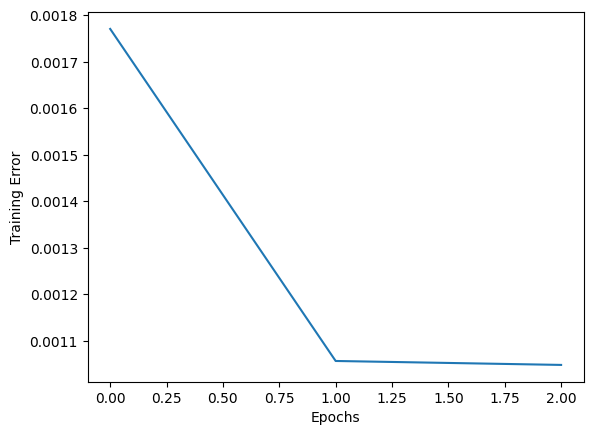

In [42]:
n_epochs = 3
steps_per_epoch = 100000

if os.path.exists("regression_model6.h5"):
    model2 = load_model("regression_model6.h5")
else:
    history = model2.fit(
        [df_train_mod.user_id, df_train_mod.product_id],
        df_train_mod.product_count_by_user,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=1,
        workers=2,
        use_multiprocessing=True,
    )
    model2.save("regression_model6.h5")
    plt.plot(history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [43]:
model2.evaluate([df_train_mod.user_id, df_train_mod.product_id], df_train_mod.product_count_by_user)

 18048/415874 [>.............................] - ETA: 6:25 - loss: 0.0071

KeyboardInterrupt: 

In [44]:
predictions = model2.predict([df_train_mod.user_id.head(10), df_train_mod.product_id.head(10)])

[print(predictions[i], df_train_mod.product_count_by_user.iloc[i]) for i in range(0,10)]

1/1 [==============================] - 0s 99ms/step
[0.03703022] 0.050505050505050504
[0.03985301] 0.050505050505050504
[0.01366869] 0.010101010101010102
[0.01113121] 0.050505050505050504
[0.02037494] 0.030303030303030304
[0.03257599] 0.0707070707070707
[0.01215989] 0.050505050505050504
[0.02101354] 0.020202020202020204
[0.01744688] 0.030303030303030304
[0.02569231] 0.1717171717171717


[None, None, None, None, None, None, None, None, None, None]

In [51]:
recommendations_pred_NN = get_recommendations_NN(model2, df_train_mod, n_rec, test_user_id_list)
recommendations_pred_NN

  0%|          | 1/1000 [00:18<5:16:05, 18.98s/it]


KeyboardInterrupt: 

In [48]:
y_pred_NN = y_true["user_id"]
y_pred_NN = pd.DataFrame(y_pred_NN)
y_pred_NN["y_pred"] = pd.DataFrame(recommendations_pred_NN).values.tolist()
y_pred_NN.head(10)

,user_id,y_pred
0,1,"[38737, 20401, 77, 469, 37313]"
1,2,"[1529, 20401, 38737, 469, 37313]"
2,5,"[5828, 20401, 469, 1529, 8906]"
3,7,"[20401, 469, 1529, 5828, 38737]"
4,8,"[5828, 8906, 469, 20401, 5622]"
5,9,"[5828, 8906, 469, 20401, 5622]"
6,10,"[8906, 5828, 469, 5622, 20401]"
7,13,"[469, 20401, 77, 38737, 26409]"
8,14,"[5828, 8906, 469, 20401, 5622]"
9,17,"[469, 20401, 38737, 1529, 26409]"


In [52]:
dataset = pd.read_csv('/Users/Artem_Boltaev/Documents/EPAM Projects/6. RecSys_course/source_code/recsys_course_epam/notebooks/instacart/ratings.csv')


In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [57]:
dataset.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [58]:
n_users = len(dataset.user_id.unique())
n_users

n_books = len(dataset.book_id.unique())
n_books

10000

In [61]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [62]:
from keras.layers import Concatenate

# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

Epoch 1/2
24544/24544 [==============================] - 255s 10ms/step - loss: 0.8443
Epoch 2/2
24544/24544 [==============================] - 256s 10ms/step - loss: 0.7296


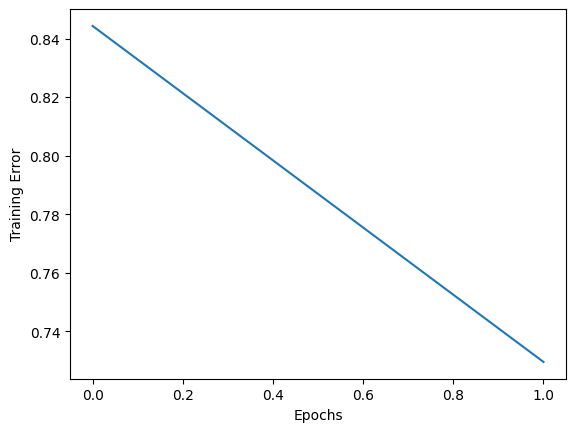

In [65]:
from keras.models import load_model

if os.path.exists('regression_model7.h5'):
    model2 = load_model('regression_model7.h5')
else:
    history = model2.fit([train.user_id, train.book_id], train.rating, epochs=2, verbose=1)
    model2.save('regression_model7.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [68]:
y_true = (
    test.groupby("user_id")["book_id"]
    .agg(lambda x: list(x))
    .reset_index(name="y_true")
).iloc[:n_users_for_rec]
y_true

df_train_mod = train.copy()
df_train_mod.rename(columns={'book_id': 'product_id'}, inplace=True)

test_user_id_list = y_true.user_id.unique().tolist()

recommendations_pred_NN = get_recommendations_NN(model2, df_train_mod, n_rec, test_user_id_list)
recommendations_pred_NN

100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s]


[[7604, 9122, 1901, 7423, 5379],
 [7604, 9443, 3167, 1901, 5493],
 [7604, 9122, 8459, 1901, 9443],
 [7604, 9122, 9443, 8459, 3167],
 [7604, 9122, 8459, 1901, 9443],
 [7604, 9443, 9122, 5493, 8459],
 [5493, 9443, 3167, 8459, 2357],
 [7604, 9122, 1901, 5379, 5016],
 [7604, 9122, 1901, 5493, 6002],
 [7604, 1901, 9122, 5493, 9443],
 [484, 1648, 510, 9443, 5493],
 [7604, 9122, 1901, 7423, 2950],
 [7604, 9122, 8459, 1901, 9443],
 [5493, 9443, 3167, 1648, 484],
 [5493, 9443, 3167, 8459, 2357],
 [3167, 7604, 9443, 8459, 5493],
 [9443, 7604, 3167, 5493, 9122],
 [1901, 5493, 9122, 2478, 5379],
 [7604, 9122, 1901, 3167, 5379],
 [7604, 9122, 3167, 8459, 5493],
 [7604, 9122, 8459, 1901, 9443],
 [8260, 2585, 276, 8797, 322],
 [7604, 1901, 9122, 9443, 3167],
 [1901, 7604, 9122, 5379, 5016],
 [8387, 7604, 8305, 1901, 5449],
 [5493, 3167, 9443, 2357, 4874],
 [7604, 9122, 1901, 5493, 5379],
 [5493, 8459, 9443, 3167, 7604],
 [7604, 9122, 5493, 9443, 1901],
 [3167, 9443, 7604, 9122, 5493],
 [8260, 2585, 2

In [69]:
predictions = model2.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

1/1 [==============================] - 0s 163ms/step
[4.979377] 5
[3.7165728] 4
[3.0080526] 3
[3.9419289] 5
[3.3242867] 3
[4.1937237] 3
[3.7208333] 3
[4.5256953] 4
[3.7417674] 3
[3.8059893] 5


[None, None, None, None, None, None, None, None, None, None]

In [70]:



y_pred_NN = y_true["user_id"]
y_pred_NN = pd.DataFrame(y_pred_NN)
y_pred_NN["y_pred"] = pd.DataFrame(recommendations_pred_NN).values.tolist()

get_scores(y_true, y_pred_NN, k=3)

hit_rate_at_k 0.001 
mean_average_precision_at_k 0.001 
ndcg_at_k 0.0004697484744972537


In [72]:
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [80]:
predictions = model2.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

313/313 [==============================] - 1s 3ms/step


array([9075, 4482, 8853, 1307, 5206])

In [82]:
book_data

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [81]:

predictions

array([4.022476 , 3.9972868, 2.9685283, ..., 4.024567 , 3.7668004,
       3.6577396], dtype=float32)

In [79]:
(-predictions).argsort()[:5]

array([9999, 9998, 9997, 9996, 9995])

In [41]:
df_train_mod.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_count_by_user,roduct_count_by_user
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,0.050505,0.050505
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,0.050505,0.050505
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,0.010101,0.010101
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,0.050505,0.050505
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,0.030303,0.030303


### 4.3.1 Evaluation

In [49]:
get_scores(y_true, y_pred_NN, k=3)

hit_rate_at_k 0.0 
mean_average_precision_at_k 0.0 
ndcg_at_k 0.0


### 4.3.2 Visualizing Neural Network

In [129]:
model2.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product-Embedding (Embedding)  (None, 1, 5)         248445      ['product-Input[0][0]']          
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         1031050     ['User-Input[0][0]']             
                                                                                            

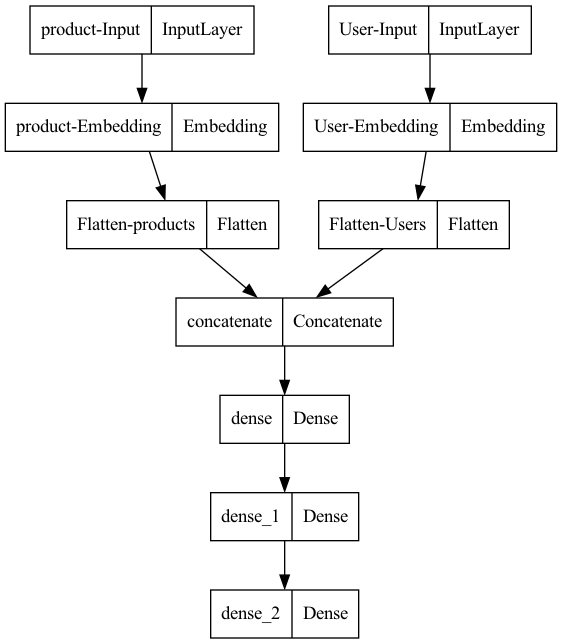

In [15]:
plot_model(model2, to_file='model.png')

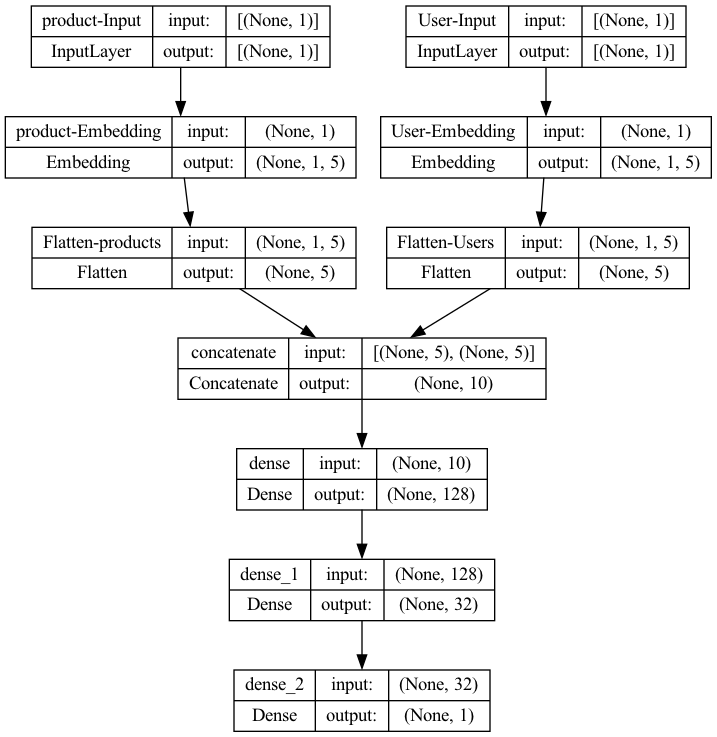

In [20]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 4.4 Nearest Neighbor recommender
utilizing SVD embeddings and annoy library for fast neighbors search

## 4.5 ALS recommender from the implicit library

## 4.6 Gradient boosting recommender utilizing SVD embedding 

# 5. Results

n_users = 1000

Algorithm Name | MAP@k | HitRate@k | NDCG@k | Time fit [c] | Time predict [c]
---------------|:------|:----------|:-------|:------|:------
Most Popular| 0.1270 | 0.1270 | 0.0577 | 1.4 | 0.7
SVD| 0.1350 | 0.1024 | 0.0512| 680 | 240
Neural Network| - | - | - | - | -
Nearest Neighbor| - | - | - | - | -
ALS| - | - | - | - | -
Gradient Boosting| - | - | - | - | -